### Data Loading And shortening..

In [1]:
# Data Fetching as Pandas.DataFrame
import pandas as pd
import warnings
warnings.filterwarnings('ignore') 

xslfile = '11poets_Selected_Yemenies_Poems.xlsx'
y_poems = pd.read_excel(xslfile, index_col=0)
y_poems.columns = ['pname', "pid", 'ptitle', 'verses', "tenv"]
y_poems = y_poems.drop_duplicates(subset=['verses'], keep='first')
y_poems = y_poems[['pname', "pid", 'ptitle', 'verses']]
y_poems.head(2)

,pname,pid,ptitle,verses
0,عبدالله البردوني,1,ابو تمام و عروبة اليوم,أصدق السيف ينضه الكذب أكذب السيف يصدق الغضب يض...
10,عبدالله البردوني,1,من أرض بلقيس,أرض بلقيس اللحن والوتر جوها الأنسام والسحر صدر...


In [2]:
# Obtaining words frequency to findout the suitable valaue for max_len
from collections import Counter
df = y_poems.copy()
all_text = ' '.join(df['verses']) 
words = all_text.split() 
word_frequencies = Counter(words)

frequency_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

frequency_df.tail(20)
frequency_df.shape, frequency_df.Frequency.unique().shape
frequency_df.shape[0], frequency_df[frequency_df.Frequency<5].shape[0]

(62811, 55699)

In [3]:
print(y_poems.shape, y_poems.isna().sum().sum(), y_poems.columns, y_poems.pid.unique().shape)
verses_count = y_poems.groupby('pname')['verses'].count()
pd.concat([verses_count], axis=1).reset_index()

(1197, 4) 0 Index(['pname', 'pid', 'ptitle', 'verses'], dtype='object') (11,)


,pname,verses
0,إبراهيم الحضرمي,16
1,حسن عبدالله الكاف,69
2,عبدالحكيم الفقيه,107
3,عبدالسلام الكبسي,98
4,عبدالعزيز المقالح,60
5,عبدالله البردوني,334
6,عبدالله عبدالوهاب نعمان,68
7,عمارة اليمني,40
8,محمد محمود الزبيري,41
9,هناء محمد,147


# Feature Extraction Methods

In [6]:
# Functions of data preparing, splitting, and m2v and d2v training..
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec, Doc2Vec
import multiprocessing
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
import torch
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression

# Gobal vars initialization
max_len = 100
vecsize = 100
mincount = 10
wd_epochs = 10
drop_out = 0.5
bsize = 32
epchz = 10

def data_prepare(df, coltxt, collbl ):
    texts = df[coltxt].values
    labels = df[collbl].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_)
    return texts, encoded_labels, num_classes

def split_and_tokenize(texts, enclabels, test_size= 0.3 ):
    X_train, X_test, y_train, y_test = train_test_split(texts, enclabels, test_size=test_size, random_state=42)    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)    
    X_train_pad = pad_sequences(train_sequences, maxlen = max_len, padding='post')
    X_test_pad = pad_sequences(test_sequences, maxlen = max_len, padding='post')
    return X_train, X_test, y_train, y_test, tokenizer, X_train_pad, X_test_pad, vocab_size

def w2v_and_d2v_(texts, test_size = 0.3):    
    tokenized_texts = [text.split() for text in texts]
    cpu_cores = multiprocessing.cpu_count()
    w2v_model = Word2Vec( sentences= tokenized_texts, vector_size= vecsize, window=5, min_count= mincount, workers=cpu_cores, 
        epochs= wd_epochs, sg = 1)
    tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(texts)]
    d2v_model = Doc2Vec( documents= tagged_data, vector_size= vecsize, window=5, min_count= mincount, workers= cpu_cores, 
        epochs= wd_epochs, dm =1)
    d2v_model.build_vocab(tagged_data)
    d2v_model.train(tagged_data, total_examples= d2v_model.corpus_count, epochs= d2v_model.epochs)
    d2v_features = np.array([d2v_model.infer_vector(text.split()) for text in texts])
    d2v_train, d2v_test = train_test_split(d2v_features, test_size = test_size, random_state=42)
    return d2v_train, d2v_test, w2v_model

## Models, layers, training, and testing ..

In [5]:
# Functions of embdding layer with w2v, and both two models process, arriving ot the accuracy of testing phase...

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Embedding layer with word2vec matrix weights...
def embeddinglayer(tokenizer, w2v_model, vocab_size, embedding_dim = 100):
    embedding_dim = embedding_dim
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    text_input = Input(shape=(max_len,))
    embedding_layer = Embedding( vocab_size, embedding_dim, weights=[embedding_matrix], input_length= max_len, 
        trainable=False)(text_input)
    return embedding_layer, text_input

# Text CNN model design, training, and testing ...
def text_cnn_train_test(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, doc2Vec_size = 100):
    num_classes = len(set(y_train))
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    pool1 = GlobalMaxPooling1D()(conv1)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    pool2 = GlobalMaxPooling1D()(conv2)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)
    pool3 = GlobalMaxPooling1D()(conv3)
    text_features = Concatenate()([pool1, pool2, pool3])
    d2v_input = Input(shape=(doc2Vec_size,))
    combined = Concatenate()([text_features, d2v_input])
    dropout = Dropout(drop_out)(combined)
    output = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=[text_input, d2v_input], outputs= output)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= ['accuracy']) 
    mdlhist = model.fit( [X_train_pad, d2v_train], y_train, batch_size= bsize, epochs= epchz, 
        validation_data=([X_test_pad, d2v_test], y_test), callbacks=[early_stopping], verbose = 2)    
    eval = model.evaluate([X_test_pad, d2v_test], y_test)
    print(f'train_acc = {mdlhist.history['accuracy'][-1]:.4f}, test_acc= {eval[1]:.4f}, the diff is = {mdlhist.history['accuracy'][-1] - eval[1] :.4f}')
    return mdlhist

# RNN LSTM model design, training, and testing ...
def rnn_lstm_train_test(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, doc2Vec_size = 100):
    num_classes = len(set(y_train))        
    lstm_layer = Bidirectional(LSTM(128))(embedding_layer)
    d2v_input = Input(shape=(doc2Vec_size,))
    combined = Concatenate()([lstm_layer, d2v_input])
    dropout = Dropout(drop_out)(combined)
    output = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=[text_input, d2v_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    mdlhist = model.fit([X_train_pad, d2v_train], y_train, batch_size= bsize, epochs= epchz, 
        validation_data = ([X_test_pad, d2v_test], y_test), callbacks=[early_stopping], verbose = 2)    
    eval = model.evaluate([X_test_pad, d2v_test], y_test)    
    print(f'train_acc = {mdlhist.history['accuracy'][-1]:.4f}, test_acc= {eval[1]:.4f}, the diff is = {mdlhist.history['accuracy'][-1] - eval[1] :.4f}')
    return mdlhist

def plotting_train_val(history):    
    # Extract metrics from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(train_acc) + 1)
    # Plot Accuracy
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Feature splitting, embedding and extaction ..

# Main global vars
max_len, vecsize, mincount, wd_epochs, tsize  = 300, 1000, 2, 30, 0.25

# Features
texts, labels, nclasses = data_prepare(y_poems, 'verses', 'pid' )
X_train, X_test, y_train, y_test, tokenizer, X_train_pad, X_test_pad, vocab_size = split_and_tokenize(texts, labels, tsize)
d2v_train, d2v_test, w2v_model = w2v_and_d2v_(texts, tsize)

# Embdding layers
embedding_layer, text_input = embeddinglayer(tokenizer, w2v_model, vocab_size, vecsize)
#2m:47.6s

Epoch 1/10
15/15 - 17s - 1s/step - accuracy: 0.3846 - loss: 1.8623 - val_accuracy: 0.6000 - val_loss: 1.3560
Epoch 2/10
15/15 - 15s - 990ms/step - accuracy: 0.6533 - loss: 1.1134 - val_accuracy: 0.6700 - val_loss: 1.0778
Epoch 3/10
15/15 - 14s - 936ms/step - accuracy: 0.7603 - loss: 0.8159 - val_accuracy: 0.7000 - val_loss: 0.9585
Epoch 4/10
15/15 - 14s - 943ms/step - accuracy: 0.8038 - loss: 0.6600 - val_accuracy: 0.7167 - val_loss: 0.9224
Epoch 5/10
15/15 - 15s - 1s/step - accuracy: 0.8606 - loss: 0.5339 - val_accuracy: 0.7100 - val_loss: 0.8968
Epoch 6/10
15/15 - 14s - 943ms/step - accuracy: 0.9030 - loss: 0.4435 - val_accuracy: 0.7500 - val_loss: 0.8257
Epoch 7/10
15/15 - 14s - 930ms/step - accuracy: 0.9164 - loss: 0.3820 - val_accuracy: 0.7433 - val_loss: 0.8121
Epoch 8/10
15/15 - 14s - 942ms/step - accuracy: 0.9264 - loss: 0.3486 - val_accuracy: 0.7067 - val_loss: 0.8572
Epoch 9/10
15/15 - 13s - 899ms/step - accuracy: 0.9353 - loss: 0.2865 - val_accuracy: 0.7167 - val_loss: 0.842

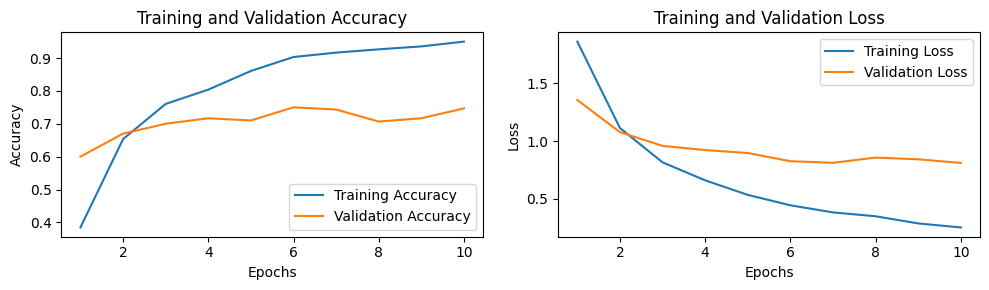

In [ ]:
drop_out, bsize, epchz = 0.5, 64, 10
hist1 = text_cnn_train_test(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist1)
#2m:26.4s 

Epoch 1/10
15/15 - 27s - 2s/step - accuracy: 0.3010 - loss: 2.0085 - val_accuracy: 0.3633 - val_loss: 1.6479
Epoch 2/10
15/15 - 23s - 2s/step - accuracy: 0.5106 - loss: 1.4488 - val_accuracy: 0.6067 - val_loss: 1.3279
Epoch 3/10
15/15 - 24s - 2s/step - accuracy: 0.6254 - loss: 1.1692 - val_accuracy: 0.6300 - val_loss: 1.1800
Epoch 4/10
15/15 - 25s - 2s/step - accuracy: 0.6856 - loss: 0.9992 - val_accuracy: 0.6233 - val_loss: 1.1392
Epoch 5/10
15/15 - 25s - 2s/step - accuracy: 0.7146 - loss: 0.9256 - val_accuracy: 0.7067 - val_loss: 0.9675
Epoch 6/10
15/15 - 25s - 2s/step - accuracy: 0.7469 - loss: 0.8388 - val_accuracy: 0.6767 - val_loss: 0.9627
Epoch 7/10
15/15 - 23s - 2s/step - accuracy: 0.7703 - loss: 0.7805 - val_accuracy: 0.7167 - val_loss: 0.8997
Epoch 8/10
15/15 - 25s - 2s/step - accuracy: 0.7737 - loss: 0.7485 - val_accuracy: 0.7100 - val_loss: 0.8927
Epoch 9/10
15/15 - 25s - 2s/step - accuracy: 0.7960 - loss: 0.6698 - val_accuracy: 0.7233 - val_loss: 0.8569
Epoch 10/10
15/15 -

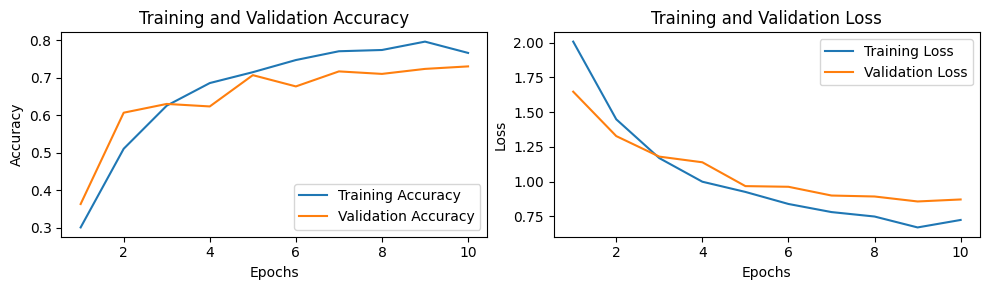

In [ ]:
hist2 = rnn_lstm_train_test(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist2)
#4m:9.7s

### Updating some of CNN and RNN hyperMeters

#### Regulizer

In [8]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

adam_optm = Adam() #(learning_rate=0.0001)
l2param = 0.001
sgd_optm = SGD(learning_rate=0.01, momentum=0.9, decay=0.01 / epchz)

# 2-Text CNN model design, training, and testing ...
def text_cnn_train_test2(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, doc2Vec_size = 100):
    num_classes = len(set(y_train))
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    pool1 = GlobalMaxPooling1D()(conv1)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    pool2 = GlobalMaxPooling1D()(conv2)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)
    pool3 = GlobalMaxPooling1D()(conv3)
    text_features = Concatenate()([pool1, pool2, pool3])

    d2v_input = Input(shape=(doc2Vec_size,))
    combined = Concatenate()([text_features, d2v_input])
    dropout = Dropout(drop_out)(combined)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2param))(dropout)
    model = Model(inputs=[text_input, d2v_input], outputs= output)
    model.compile(optimizer = adam_optm, loss='sparse_categorical_crossentropy', metrics= ['accuracy'])    
    mdlhist = model.fit( [X_train_pad, d2v_train], y_train, batch_size= bsize, epochs= epchz, 
        validation_data=([X_test_pad, d2v_test], y_test), callbacks=[early_stopping], verbose = 2)
    eval = model.evaluate([X_test_pad, d2v_test], y_test)
    print(f'train_acc = {mdlhist.history['accuracy'][-1]:.4f}, test_acc= {eval[1]:.4f}, the diff is = {mdlhist.history['accuracy'][-1] - eval[1] :.4f}')
    return mdlhist

# 2-RNN LSTM model design, training, and testing ...
def rnn_lstm_train_test2(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, doc2Vec_size = 100):
    num_classes = len(set(y_train))        
    lstm_layer = Bidirectional(LSTM(128))(embedding_layer)
    d2v_input = Input(shape=(doc2Vec_size,))
    combined = Concatenate()([lstm_layer, d2v_input])
    dropout = Dropout(drop_out)(combined)    
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2param))(dropout)
    model = Model(inputs=[text_input, d2v_input], outputs=output)
    model.compile(optimizer = adam_optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    mdlhist = model.fit([X_train_pad, d2v_train], y_train, batch_size= bsize, epochs= epchz, 
        validation_data = ([X_test_pad, d2v_test], y_test), callbacks=[early_stopping], verbose = 2)   
    eval = model.evaluate([X_test_pad, d2v_test], y_test)
    print(f'train_acc = {mdlhist.history['accuracy'][-1]:.4f}, test_acc= {eval[1]:.4f}, the diff is = {mdlhist.history['accuracy'][-1] - eval[1] :.4f}')
    return mdlhist

Epoch 1/10
29/29 - 18s - 634ms/step - accuracy: 0.4069 - loss: 1.7635 - val_accuracy: 0.6067 - val_loss: 1.2572
Epoch 2/10
29/29 - 14s - 499ms/step - accuracy: 0.6968 - loss: 0.9743 - val_accuracy: 0.6933 - val_loss: 1.0382
Epoch 3/10
29/29 - 14s - 486ms/step - accuracy: 0.8116 - loss: 0.6778 - val_accuracy: 0.7000 - val_loss: 0.9883
Epoch 4/10
29/29 - 15s - 505ms/step - accuracy: 0.8629 - loss: 0.5320 - val_accuracy: 0.7167 - val_loss: 0.9294
Epoch 5/10
29/29 - 15s - 506ms/step - accuracy: 0.9030 - loss: 0.4207 - val_accuracy: 0.7267 - val_loss: 0.8898
Epoch 6/10
29/29 - 15s - 502ms/step - accuracy: 0.9064 - loss: 0.3908 - val_accuracy: 0.7167 - val_loss: 0.9332
Epoch 7/10
29/29 - 14s - 491ms/step - accuracy: 0.8997 - loss: 0.3784 - val_accuracy: 0.7400 - val_loss: 0.9048
Epoch 8/10
29/29 - 15s - 501ms/step - accuracy: 0.9052 - loss: 0.3489 - val_accuracy: 0.7567 - val_loss: 0.8640
Epoch 9/10
29/29 - 15s - 517ms/step - accuracy: 0.9465 - loss: 0.2509 - val_accuracy: 0.7567 - val_loss:

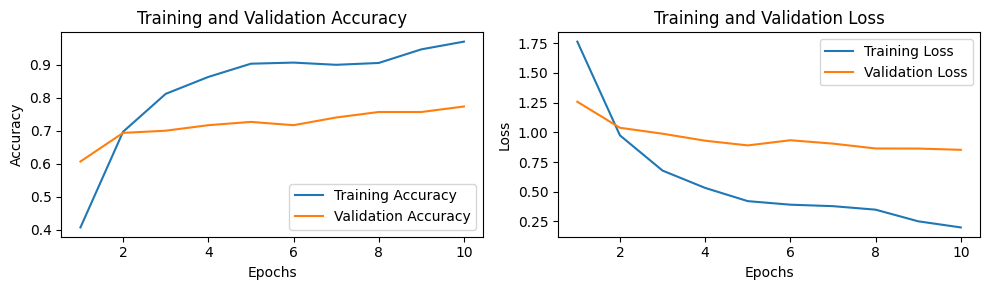

In [ ]:
drop_out, bsize, epchz = 0.5, 32, 10
hist1 = text_cnn_train_test2(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist1)
#2m:31.4s

Epoch 1/10
29/29 - 32s - 1s/step - accuracy: 0.3534 - loss: 1.8574 - val_accuracy: 0.4100 - val_loss: 1.5375
Epoch 2/10
29/29 - 30s - 1s/step - accuracy: 0.5552 - loss: 1.3252 - val_accuracy: 0.6700 - val_loss: 1.2059
Epoch 3/10
29/29 - 27s - 931ms/step - accuracy: 0.6957 - loss: 1.0196 - val_accuracy: 0.6767 - val_loss: 1.0224
Epoch 4/10
29/29 - 25s - 870ms/step - accuracy: 0.7179 - loss: 0.9741 - val_accuracy: 0.6300 - val_loss: 1.1706
Epoch 5/10
29/29 - 26s - 895ms/step - accuracy: 0.7068 - loss: 0.9609 - val_accuracy: 0.6633 - val_loss: 1.0215
Epoch 6/10
29/29 - 27s - 920ms/step - accuracy: 0.7670 - loss: 0.8281 - val_accuracy: 0.7300 - val_loss: 0.9323
Epoch 7/10
29/29 - 29s - 998ms/step - accuracy: 0.7726 - loss: 0.7647 - val_accuracy: 0.7367 - val_loss: 0.8973
Epoch 8/10
29/29 - 28s - 954ms/step - accuracy: 0.8016 - loss: 0.6826 - val_accuracy: 0.6900 - val_loss: 0.9417
Epoch 9/10
29/29 - 28s - 965ms/step - accuracy: 0.7848 - loss: 0.6866 - val_accuracy: 0.7333 - val_loss: 0.848

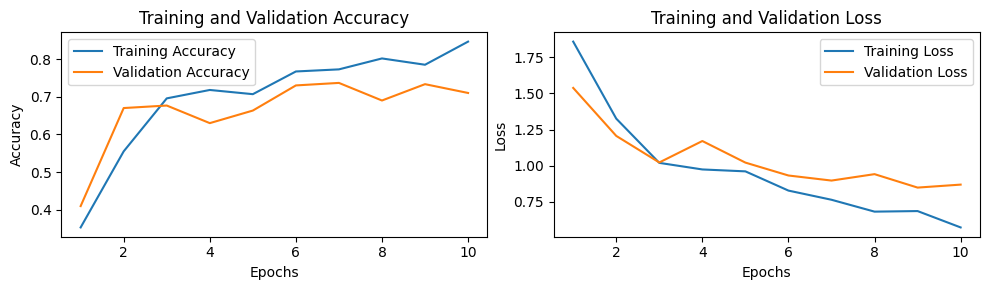

In [ ]:
drop_out, bsize, epchz = 0.5, 32, 10
hist2 = rnn_lstm_train_test2(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist2)
#4m:43.3s

In [ ]:
drop_out, bsize, epchz = 0.5, 64, 10
hist1 = text_cnn_train_test2(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist1)
#2m:24.1s

Epoch 1/10
29/29 - 32s - 1s/step - accuracy: 0.3802 - loss: 1.8478 - val_accuracy: 0.4333 - val_loss: 1.5055
Epoch 2/10
29/29 - 28s - 959ms/step - accuracy: 0.5853 - loss: 1.2766 - val_accuracy: 0.6767 - val_loss: 1.2261
Epoch 3/10
29/29 - 29s - 1000ms/step - accuracy: 0.6789 - loss: 1.0949 - val_accuracy: 0.6767 - val_loss: 1.1266
Epoch 4/10
29/29 - 29s - 1s/step - accuracy: 0.7235 - loss: 0.9237 - val_accuracy: 0.7033 - val_loss: 0.9830
Epoch 5/10
29/29 - 28s - 952ms/step - accuracy: 0.7458 - loss: 0.8239 - val_accuracy: 0.6400 - val_loss: 1.0803
Epoch 6/10
29/29 - 26s - 907ms/step - accuracy: 0.7369 - loss: 0.8180 - val_accuracy: 0.7167 - val_loss: 0.9499
Epoch 7/10
29/29 - 26s - 904ms/step - accuracy: 0.7637 - loss: 0.7538 - val_accuracy: 0.7467 - val_loss: 0.8757
Epoch 8/10
29/29 - 28s - 973ms/step - accuracy: 0.8004 - loss: 0.6575 - val_accuracy: 0.7367 - val_loss: 0.8376
Epoch 9/10
29/29 - 29s - 1s/step - accuracy: 0.8317 - loss: 0.5883 - val_accuracy: 0.7367 - val_loss: 0.8971


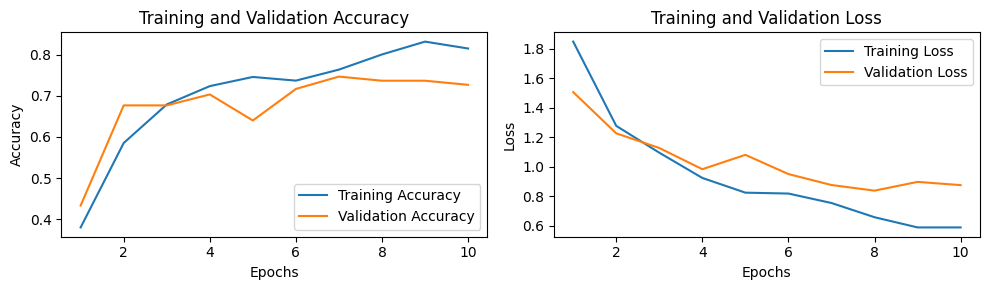

In [ ]:
hist2 = rnn_lstm_train_test2(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist2)
#4m:46.4s

####

#### Optimizer

In [27]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

adam_optm = Adam(learning_rate=0.0005)
#sgd_optm = SGD()
#sgd_optm = SGD(learning_rate=0.01, momentum=0.9, decay=0.01 / epchz)

# 2-Text CNN model design, training, and testing ...
def text_cnn_train_test3(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, doc2Vec_size = 100):
    num_classes = len(set(y_train))
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    pool1 = GlobalMaxPooling1D()(conv1)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    pool2 = GlobalMaxPooling1D()(conv2)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)
    pool3 = GlobalMaxPooling1D()(conv3)
    text_features = Concatenate()([pool1, pool2, pool3])

    d2v_input = Input(shape=(doc2Vec_size,))
    combined = Concatenate()([text_features, d2v_input])
    dropout = Dropout(drop_out)(combined)
    output = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=[text_input, d2v_input], outputs= output)
    model.compile(optimizer = adam_optm, loss='sparse_categorical_crossentropy', metrics= ['accuracy'])    
    mdlhist = model.fit( [X_train_pad, d2v_train], y_train, batch_size= bsize, epochs= epchz, 
        validation_data=([X_test_pad, d2v_test], y_test), callbacks=[early_stopping], verbose = 2)
    eval = model.evaluate([X_test_pad, d2v_test], y_test)
    print(f'train_acc = {mdlhist.history['accuracy'][-1]:.4f}, test_acc= {eval[1]:.4f}, the diff is = {mdlhist.history['accuracy'][-1] - eval[1] :.4f}')
    return mdlhist

# 2-RNN LSTM model design, training, and testing ...
def rnn_lstm_train_test3(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, doc2Vec_size = 100):
    num_classes = len(set(y_train))        
    lstm_layer = Bidirectional(LSTM(128))(embedding_layer)
    d2v_input = Input(shape=(doc2Vec_size,))
    combined = Concatenate()([lstm_layer, d2v_input])
    dropout = Dropout(drop_out)(combined)    
    output = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=[text_input, d2v_input], outputs=output)
    model.compile(optimizer = adam_optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    mdlhist = model.fit([X_train_pad, d2v_train], y_train, batch_size= bsize, epochs= epchz, 
        validation_data = ([X_test_pad, d2v_test], y_test), callbacks=[early_stopping], verbose = 2)   
    eval = model.evaluate([X_test_pad, d2v_test], y_test)
    print(f'train_acc = {mdlhist.history['accuracy'][-1]:.4f}, test_acc= {eval[1]:.4f}, the diff is = {mdlhist.history['accuracy'][-1] - eval[1] :.4f}')
    return mdlhist

Epoch 1/10
15/15 - 15s - 982ms/step - accuracy: 0.2219 - loss: 2.2523 - val_accuracy: 0.3233 - val_loss: 1.9806
Epoch 2/10
15/15 - 14s - 948ms/step - accuracy: 0.3177 - loss: 1.9867 - val_accuracy: 0.3433 - val_loss: 1.8752
Epoch 3/10
15/15 - 14s - 955ms/step - accuracy: 0.3556 - loss: 1.8452 - val_accuracy: 0.2867 - val_loss: 1.7834
Epoch 4/10
15/15 - 14s - 915ms/step - accuracy: 0.3913 - loss: 1.7443 - val_accuracy: 0.4333 - val_loss: 1.6920
Epoch 5/10
15/15 - 14s - 929ms/step - accuracy: 0.4225 - loss: 1.6906 - val_accuracy: 0.4767 - val_loss: 1.6324
Epoch 6/10
15/15 - 14s - 942ms/step - accuracy: 0.4649 - loss: 1.6105 - val_accuracy: 0.4533 - val_loss: 1.5819
Epoch 7/10
15/15 - 14s - 924ms/step - accuracy: 0.4783 - loss: 1.5551 - val_accuracy: 0.4800 - val_loss: 1.5227
Epoch 8/10
15/15 - 14s - 943ms/step - accuracy: 0.4849 - loss: 1.4848 - val_accuracy: 0.4767 - val_loss: 1.4889
Epoch 9/10
15/15 - 13s - 890ms/step - accuracy: 0.4838 - loss: 1.4697 - val_accuracy: 0.4933 - val_loss:

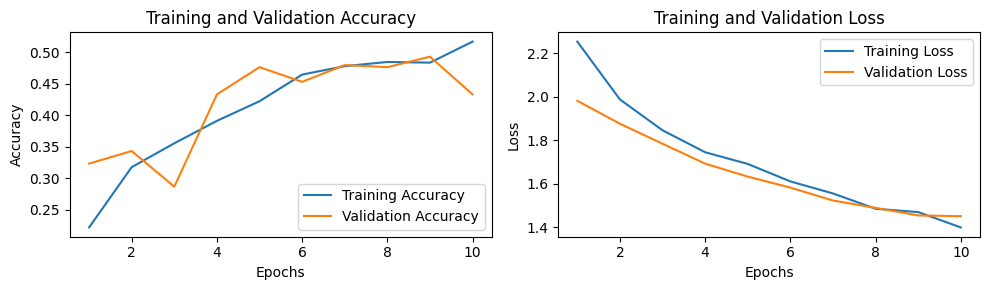

In [ ]:
# for SGD optimizer
drop_out, bsize, epchz = 0.5, 64, 10
hist1 = text_cnn_train_test3(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist1)
#2m:24.9s

Epoch 1/10
15/15 - 26s - 2s/step - accuracy: 0.1014 - loss: 2.4724 - val_accuracy: 0.3167 - val_loss: 2.1942
Epoch 2/10
15/15 - 23s - 2s/step - accuracy: 0.2620 - loss: 2.1653 - val_accuracy: 0.3533 - val_loss: 2.0034
Epoch 3/10
15/15 - 23s - 2s/step - accuracy: 0.3668 - loss: 1.9846 - val_accuracy: 0.3767 - val_loss: 1.9051
Epoch 4/10
15/15 - 24s - 2s/step - accuracy: 0.4025 - loss: 1.8760 - val_accuracy: 0.3767 - val_loss: 1.8061
Epoch 5/10
15/15 - 23s - 2s/step - accuracy: 0.4058 - loss: 1.7771 - val_accuracy: 0.3900 - val_loss: 1.7419
Epoch 6/10
15/15 - 24s - 2s/step - accuracy: 0.4292 - loss: 1.7129 - val_accuracy: 0.4267 - val_loss: 1.6867
Epoch 7/10
15/15 - 22s - 1s/step - accuracy: 0.4392 - loss: 1.6637 - val_accuracy: 0.4733 - val_loss: 1.6360
Epoch 8/10
15/15 - 23s - 2s/step - accuracy: 0.4671 - loss: 1.6223 - val_accuracy: 0.4733 - val_loss: 1.5967
Epoch 9/10
15/15 - 23s - 2s/step - accuracy: 0.4749 - loss: 1.5782 - val_accuracy: 0.4867 - val_loss: 1.5642
Epoch 10/10
15/15 -

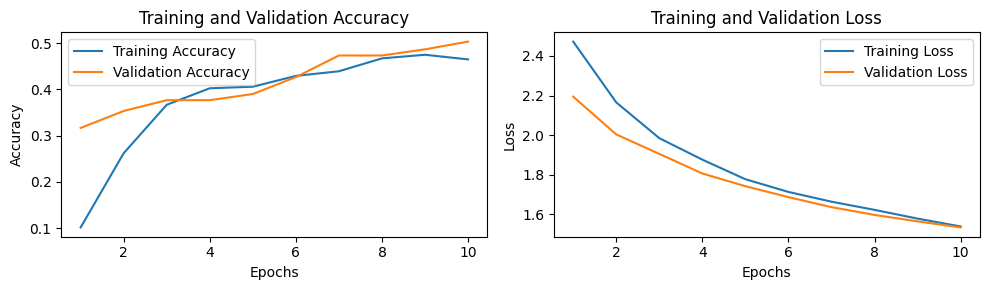

In [ ]:
# for SGD optimizer
hist2 = rnn_lstm_train_test3(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist2)
#4m:0.2s

Epoch 1/10
15/15 - 17s - 1s/step - accuracy: 0.2542 - loss: 2.1145 - val_accuracy: 0.4567 - val_loss: 1.7206
Epoch 2/10
15/15 - 14s - 947ms/step - accuracy: 0.5284 - loss: 1.4627 - val_accuracy: 0.5200 - val_loss: 1.3974
Epoch 3/10
15/15 - 14s - 923ms/step - accuracy: 0.6622 - loss: 1.1361 - val_accuracy: 0.6033 - val_loss: 1.2179
Epoch 4/10
15/15 - 14s - 909ms/step - accuracy: 0.7402 - loss: 0.9221 - val_accuracy: 0.6633 - val_loss: 1.1190
Epoch 5/10
15/15 - 14s - 909ms/step - accuracy: 0.7815 - loss: 0.7905 - val_accuracy: 0.6800 - val_loss: 1.0453
Epoch 6/10
15/15 - 14s - 915ms/step - accuracy: 0.8149 - loss: 0.7056 - val_accuracy: 0.6600 - val_loss: 1.0291
Epoch 7/10
15/15 - 14s - 915ms/step - accuracy: 0.8484 - loss: 0.6273 - val_accuracy: 0.6867 - val_loss: 0.9807
Epoch 8/10
15/15 - 14s - 900ms/step - accuracy: 0.8573 - loss: 0.5874 - val_accuracy: 0.6933 - val_loss: 0.9426
Epoch 9/10
15/15 - 14s - 905ms/step - accuracy: 0.8829 - loss: 0.5038 - val_accuracy: 0.7167 - val_loss: 0.

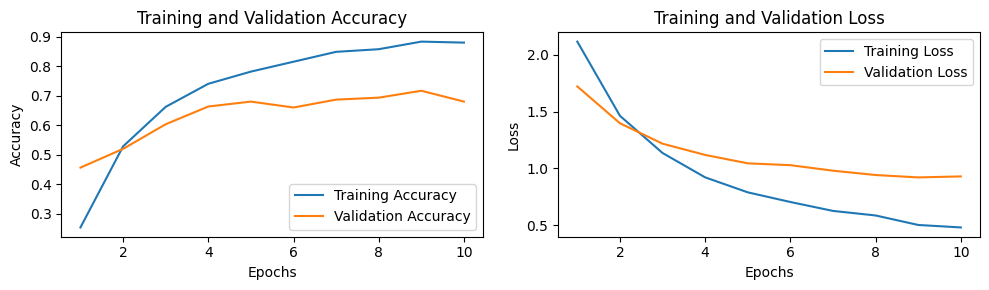

In [ ]:
# For ِadam and lr=.0005 optimizer
drop_out, bsize, epchz = 0.5, 64, 10
hist1 = text_cnn_train_test3(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist1)
#2m:22.8s

Epoch 1/10
15/15 - 26s - 2s/step - accuracy: 0.2230 - loss: 2.2434 - val_accuracy: 0.2900 - val_loss: 1.8795
Epoch 2/10
15/15 - 22s - 1s/step - accuracy: 0.3690 - loss: 1.7863 - val_accuracy: 0.4833 - val_loss: 1.6252
Epoch 3/10
15/15 - 23s - 2s/step - accuracy: 0.5095 - loss: 1.5126 - val_accuracy: 0.6300 - val_loss: 1.4205
Epoch 4/10
15/15 - 23s - 2s/step - accuracy: 0.5909 - loss: 1.3551 - val_accuracy: 0.6333 - val_loss: 1.3064
Epoch 5/10
15/15 - 24s - 2s/step - accuracy: 0.6511 - loss: 1.1949 - val_accuracy: 0.6367 - val_loss: 1.1700
Epoch 6/10
15/15 - 24s - 2s/step - accuracy: 0.6767 - loss: 1.0631 - val_accuracy: 0.6800 - val_loss: 1.0881
Epoch 7/10
15/15 - 24s - 2s/step - accuracy: 0.6700 - loss: 1.0262 - val_accuracy: 0.7000 - val_loss: 1.0499
Epoch 8/10
15/15 - 24s - 2s/step - accuracy: 0.7191 - loss: 0.9370 - val_accuracy: 0.7033 - val_loss: 1.0202
Epoch 9/10
15/15 - 25s - 2s/step - accuracy: 0.7447 - loss: 0.8721 - val_accuracy: 0.7133 - val_loss: 0.9506
Epoch 10/10
15/15 -

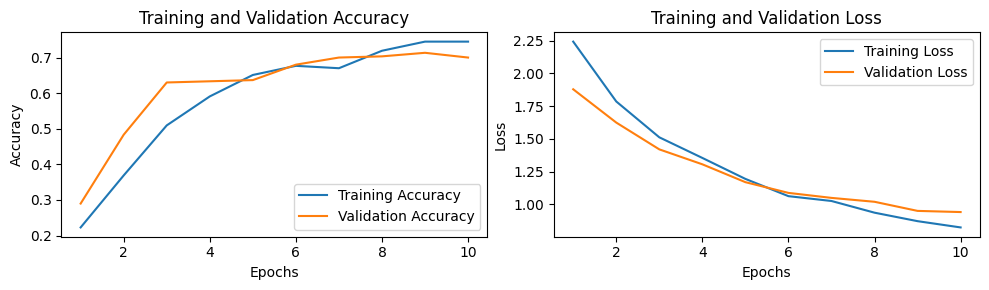

In [ ]:
# For ِadam and lr=.0005 optimizer
hist2 = rnn_lstm_train_test3(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist2)
#4m:0.9s

### Fixing CNN overfitting by drop out to 0.7

Epoch 1/10
15/15 - 16s - 1s/step - accuracy: 0.2977 - loss: 2.1413 - val_accuracy: 0.4967 - val_loss: 1.4728
Epoch 2/10
15/15 - 14s - 939ms/step - accuracy: 0.5206 - loss: 1.3955 - val_accuracy: 0.6300 - val_loss: 1.2451
Epoch 3/10
15/15 - 14s - 949ms/step - accuracy: 0.6466 - loss: 1.1223 - val_accuracy: 0.6533 - val_loss: 1.1061
Epoch 4/10
15/15 - 15s - 988ms/step - accuracy: 0.7469 - loss: 0.8661 - val_accuracy: 0.6767 - val_loss: 1.0136
Epoch 5/10
15/15 - 14s - 940ms/step - accuracy: 0.7536 - loss: 0.7994 - val_accuracy: 0.6900 - val_loss: 0.9914
Epoch 6/10
15/15 - 14s - 912ms/step - accuracy: 0.7882 - loss: 0.7068 - val_accuracy: 0.7000 - val_loss: 0.9536
Epoch 7/10
15/15 - 14s - 914ms/step - accuracy: 0.7960 - loss: 0.6591 - val_accuracy: 0.6967 - val_loss: 0.9341
Epoch 8/10
15/15 - 14s - 906ms/step - accuracy: 0.8283 - loss: 0.5847 - val_accuracy: 0.7167 - val_loss: 0.9174
Epoch 9/10
15/15 - 14s - 941ms/step - accuracy: 0.8517 - loss: 0.5329 - val_accuracy: 0.7133 - val_loss: 0.

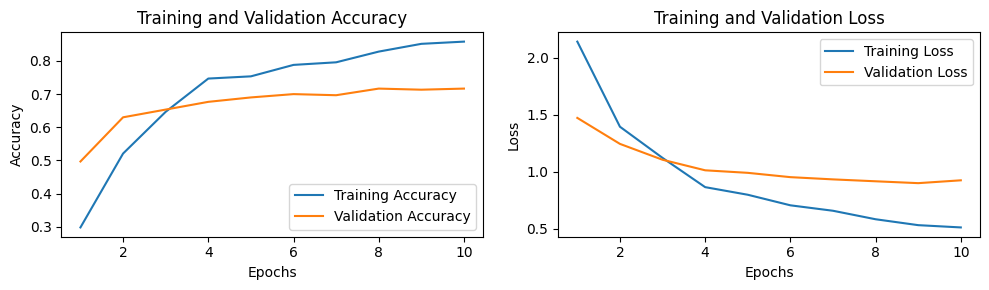

In [ ]:
drop_out, bsize, epchz = 0.7, 64, 10
hist1 = text_cnn_train_test(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist1)
#2m:25.1s 

Epoch 1/10
15/15 - 28s - 2s/step - accuracy: 0.2319 - loss: 2.2072 - val_accuracy: 0.3700 - val_loss: 1.7365
Epoch 2/10
15/15 - 24s - 2s/step - accuracy: 0.4080 - loss: 1.6785 - val_accuracy: 0.5000 - val_loss: 1.4638
Epoch 3/10
15/15 - 25s - 2s/step - accuracy: 0.5295 - loss: 1.4124 - val_accuracy: 0.6133 - val_loss: 1.2963
Epoch 4/10
15/15 - 25s - 2s/step - accuracy: 0.6098 - loss: 1.2230 - val_accuracy: 0.5267 - val_loss: 1.2720
Epoch 5/10
15/15 - 25s - 2s/step - accuracy: 0.6009 - loss: 1.1878 - val_accuracy: 0.6500 - val_loss: 1.1406
Epoch 6/10
15/15 - 25s - 2s/step - accuracy: 0.6644 - loss: 1.0429 - val_accuracy: 0.6933 - val_loss: 1.0458
Epoch 7/10
15/15 - 25s - 2s/step - accuracy: 0.6656 - loss: 0.9869 - val_accuracy: 0.7133 - val_loss: 0.9791
Epoch 8/10
15/15 - 25s - 2s/step - accuracy: 0.7425 - loss: 0.8647 - val_accuracy: 0.6967 - val_loss: 0.9222
Epoch 9/10
15/15 - 26s - 2s/step - accuracy: 0.7168 - loss: 0.8365 - val_accuracy: 0.6800 - val_loss: 0.9440
Epoch 10/10
15/15 -

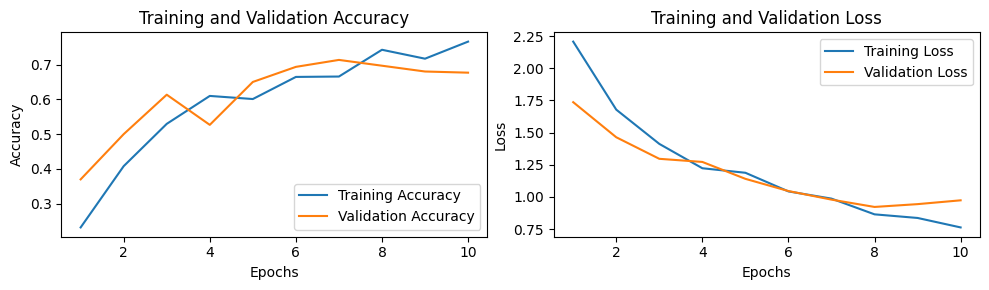

In [ ]:
drop_out, bsize, epchz = 0.7, 64, 10
hist2 = rnn_lstm_train_test(embedding_layer, text_input, X_train_pad, d2v_train, y_train, X_test_pad, d2v_test, y_test, vecsize)
plotting_train_val(hist2)
#4m:15.6s